In [68]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# FUNCTIONS

In [69]:
def describe_in_xarray(ds: xr.Dataset):
    print(f"\t\t Mean \t   Std \t     Min\tMax")
    for var_name, variable in ds.data_vars.items():
        # We only calculate the stats for numeric variables
        mean = variable.mean().values
        std = variable.std().values
        min = variable.min().values
        max = variable.max().values
        print(f"{var_name:<10}     {mean:^7.3f}   {std:^7.3f}   {min:^7.3f}   {max:^7.3f}")

In [70]:
def print_nan_calculatations(dsx: xr.Dataset):
    for var_name, data_array in dsx.data_vars.items():
        # Calculate the total number of NaN and non-NaN values
        total_nan = data_array.isnull().sum().item()
        total_non_nan = data_array.notnull().sum().item()

        # Calculate the total number of elements
        total_elements = data_array.size

        # Calculate percentages
        nan_percentage = (total_nan / total_elements) * 100
        non_nan_percentage = (total_non_nan / total_elements) * 100

        # Print the results
        print(f"{var_name:<10} Total NaNs: {total_nan:^10} Total Non-Nan: {total_non_nan:^10} NaN Percentage: {nan_percentage:^4.2f}%   Non-NaN Percentage: {non_nan_percentage:^4.2f}%")

# SSM LST Exploratory Data Analysis

In [71]:
# Only a few months to check
path_SL_01_18 = "../data/raw/SSM_LST_01_2018.nc"
path_SL_02_18 = "../data/raw/SSM_LST_02_2018.nc"

In [72]:
ds = xr.open_dataset(path_SL_01_18)
ds2 = xr.open_dataset(path_SL_02_18)
ds = xr.concat([ds, ds2], dim="time")


In [73]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 71, latitude: 41, time: 1416)
Coordinates:
  * longitude  (longitude) float32 -8.0 -7.9 -7.8 -7.7 ... -1.3 -1.2 -1.1 -1.0
  * latitude   (latitude) float32 39.0 38.9 38.8 38.7 ... 35.3 35.2 35.1 35.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-02-28T23:00:00
Data variables:
    stl1       (time, latitude, longitude) float32 281.3 281.9 ... 284.3 283.9
    tp         (time, latitude, longitude) float32 0.001718 ... 1.593e-06
    swvl1      (time, latitude, longitude) float32 0.2324 0.3148 ... 0.3336
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-22 01:45:49 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

In [74]:
ds.head()

<xarray.Dataset>
Dimensions:    (longitude: 5, latitude: 5, time: 5)
Coordinates:
  * longitude  (longitude) float32 -8.0 -7.9 -7.8 -7.7 -7.6
  * latitude   (latitude) float32 39.0 38.9 38.8 38.7 38.6
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-01-01T04:00:00
Data variables:
    stl1       (time, latitude, longitude) float32 281.3 281.9 ... 280.1 279.9
    tp         (time, latitude, longitude) float32 0.001718 0.001616 ... 0.0 0.0
    swvl1      (time, latitude, longitude) float32 0.2324 0.3148 ... 0.3016
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-22 01:45:49 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

In [75]:
print("Dataset Info:")
print(ds.info())


Dataset Info:
xarray.Dataset {
dimensions:
	longitude = 71 ;
	latitude = 41 ;
	time = 1416 ;

variables:
	float32 longitude(longitude) ;
		longitude:units = degrees_east ;
		longitude:long_name = longitude ;
	float32 latitude(latitude) ;
		latitude:units = degrees_north ;
		latitude:long_name = latitude ;
	datetime64[ns] time(time) ;
		time:long_name = time ;
	float32 stl1(time, latitude, longitude) ;
		stl1:units = K ;
		stl1:long_name = Soil temperature level 1 ;
		stl1:standard_name = surface_temperature ;
	float32 tp(time, latitude, longitude) ;
		tp:units = m ;
		tp:long_name = Total precipitation ;
	float32 swvl1(time, latitude, longitude) ;
		swvl1:units = m**3 m**-3 ;
		swvl1:long_name = Volumetric soil water layer 1 ;

// global attributes:
	:Conventions = CF-1.6 ;
	:history = 2023-11-22 01:45:49 GMT by grib_to_netcdf-2.24.0: /opt/ecmwf/eccodes/bin/grib_to_netcdf -S param -o /cache/tmp/1b6e4a80-a7b5-4f19-ae05-90b7d59726ec-adaptor.mars.internal-1700617545.4094186-14446-12-tmp.n

In [76]:
# Just to make sure that the date values are indeed correct (from January to February)
print(ds["time"].min().values)
print(ds["time"].max().values)

2018-01-01T00:00:00.000000000
2018-02-28T23:00:00.000000000


In [77]:
# Because we don't have an specific .describe() method for xarray.Dataset
describe_in_xarray(ds)

		 Mean 	   Std 	     Min	Max
stl1           281.540    4.564    271.161   301.860
tp              0.001     0.003     0.000     0.052 
swvl1           0.296     0.076     0.038     0.520 


In [78]:
print_nan_calculatations(ds)

stl1       Total NaNs:  1588752   Total Non-Nan:  2533224   NaN Percentage: 38.54%   Non-NaN Percentage: 61.46%
tp         Total NaNs:  1588752   Total Non-Nan:  2533224   NaN Percentage: 38.54%   Non-NaN Percentage: 61.46%
swvl1      Total NaNs:  1588752   Total Non-Nan:  2533224   NaN Percentage: 38.54%   Non-NaN Percentage: 61.46%


Given that there is a value for each hour, a mean or LCF for inputing NaNs might work, however, there is a 40% of missing values,
Do we need a high fidelity dataset? Can it make our model worse?
Straight NaN drop??

In [88]:
for var_name, _ in ds.data_vars.items():
    ds[var_name] = ds[var_name].interpolate_na(dim="time", method="linear")

print_nan_calculatations(ds)

stl1       Total NaNs:  1588752   Total Non-Nan:  2533224   NaN Percentage: 38.54%   Non-NaN Percentage: 61.46%
tp         Total NaNs:  1588752   Total Non-Nan:  2533224   NaN Percentage: 38.54%   Non-NaN Percentage: 61.46%
swvl1      Total NaNs:  1588752   Total Non-Nan:  2533224   NaN Percentage: 38.54%   Non-NaN Percentage: 61.46%


The percentages are not changing, either I'm doing something wrong or there are not enought values to interpolate.
The .interpolate_na() method needs the value before and after the NaN value to interpolate, if not, it won't apply it

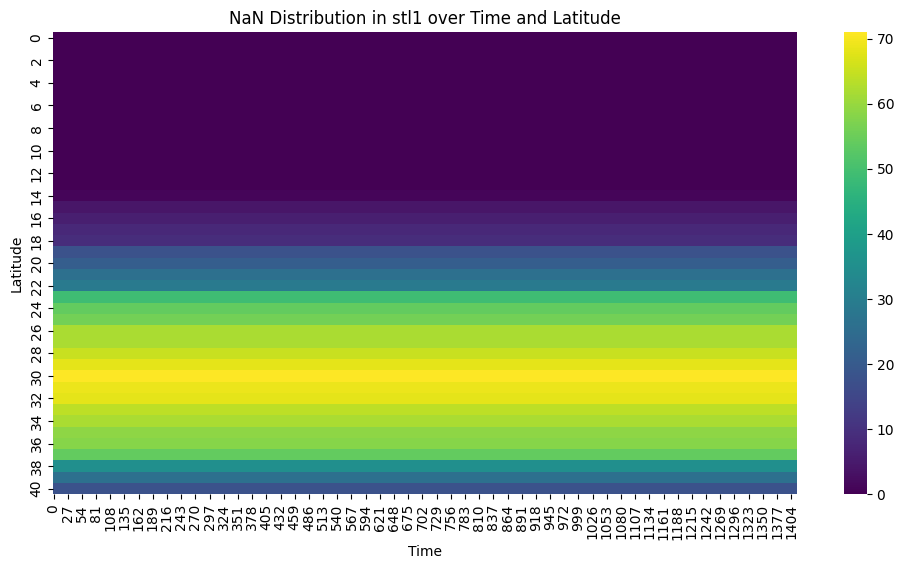

In [87]:
# NaN distribution
variable = ds['swvl1']

nan_matrix = np.isnan(variable).sum(dim='longitude').T 

plt.figure(figsize=(12, 6))
sns.heatmap(nan_matrix, cmap='viridis', cbar=True)
plt.title('NaN Distribution in stl1 over Time and Latitude')
plt.xlabel('Time')
plt.ylabel('Latitude')
plt.show()

The problem might just be that the NaNs are surrounded by at leat another NaN in most cases, which makes it impossible to use the mean of the previous and next values.
Maybe input the mean of each variable??

In [ ]:
# NaNs inputed for each variable mean
# for var_name, _ in ds.data_vars.items():
#     ds[var_name] = ds[var_name].fillna(ds[var_name].mean())

In [ ]:
# for var_name, _ in ds.data_vars.items():
#     ds[var_name] = ds[var_name].dropna(dim="time")

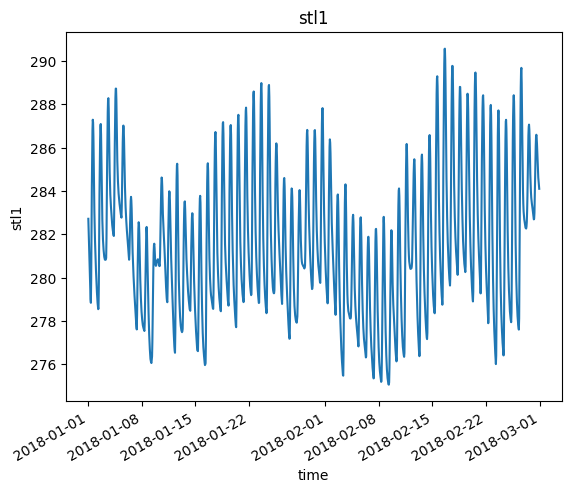

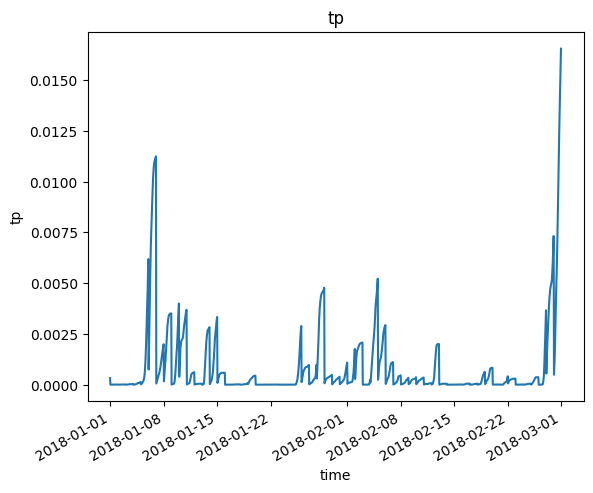

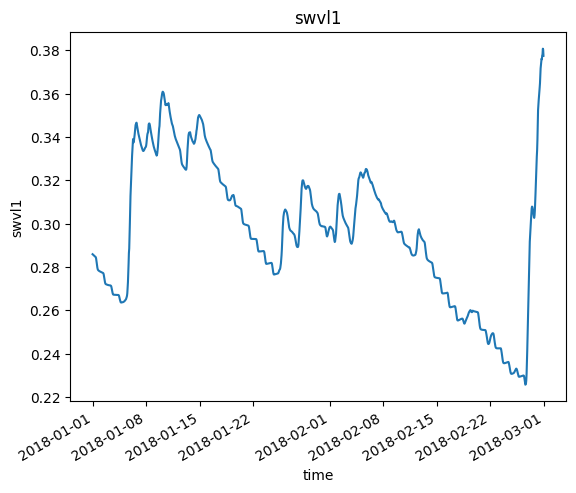

In [96]:
for var in ds.data_vars:
    ds[var].mean(dim=['latitude', 'longitude']).plot()
    plt.title(var)
    plt.show()



Standardization (Z-Score)

In [33]:
# Only for data variables
for var in ds.data_vars:
    ds[var] = (ds[var] - ds[var].mean()) / ds[var].std()

# FAPAR NVIDI Exploratory Data Analysis

In [34]:
path_fapar = "../data/raw/003-00073-00-00_BIOPAR_FAPAR_V2_GLOBAL_2006_05_08_2021_09_23.txt"
path_nvdi = "../data/raw/003-00073-00-00_BIOPAR_NDVI_V2_GLOBAL_2006_05_08_2021_09_23.txt"

In [35]:
# Even if the files are .txt, the csv method works just fine
# In this case, the data is separated by tabs, ther is an index column and the dates have to be parsed
ds_fapar = pd.read_csv(path_fapar, sep="\t", index_col=0, parse_dates=["date"])
ds_nvdi = pd.read_csv(path_nvdi, sep="\t", index_col=0, parse_dates=["date"])

In [36]:
ds_fapar = ds_fapar.rename(columns={"value": "fapar"})
ds_nvdi = ds_nvdi.rename(columns={"value": "nvdi"})
ds_fapar.describe()

,date,fapar
count,510,510.000000
mean,2013-06-05 00:16:56.470588160,0.252902
min,2006-05-10 00:00:00,0.104000
25%,2009-11-22 12:00:00,0.188000
50%,2013-06-05 00:00:00,0.252000
75%,2016-12-17 12:00:00,0.315000
max,2020-06-30 00:00:00,0.460000
std,NaN,0.080305


In [37]:
ds_nvdi.describe()

,date,nvdi
count,528,521.000000
mean,2013-09-05 08:13:38.181818368,0.345190
min,2006-05-11 00:00:00,0.220000
25%,2010-01-08 12:00:00,0.300000
50%,2013-09-06 00:00:00,0.340000
75%,2017-05-03 12:00:00,0.380000
max,2021-01-01 00:00:00,0.548000
std,NaN,0.057982


In [38]:
ds_fapar.info()

<class 'pandas.core.frame.DataFrame'>
Index: 510 entries, 0 to 509
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    510 non-null    datetime64[ns]
 1   fapar   510 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.0 KB


In [39]:
ds_nvdi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 528 entries, 0 to 527
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    528 non-null    datetime64[ns]
 1   nvdi    521 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.4 KB


FAPAR

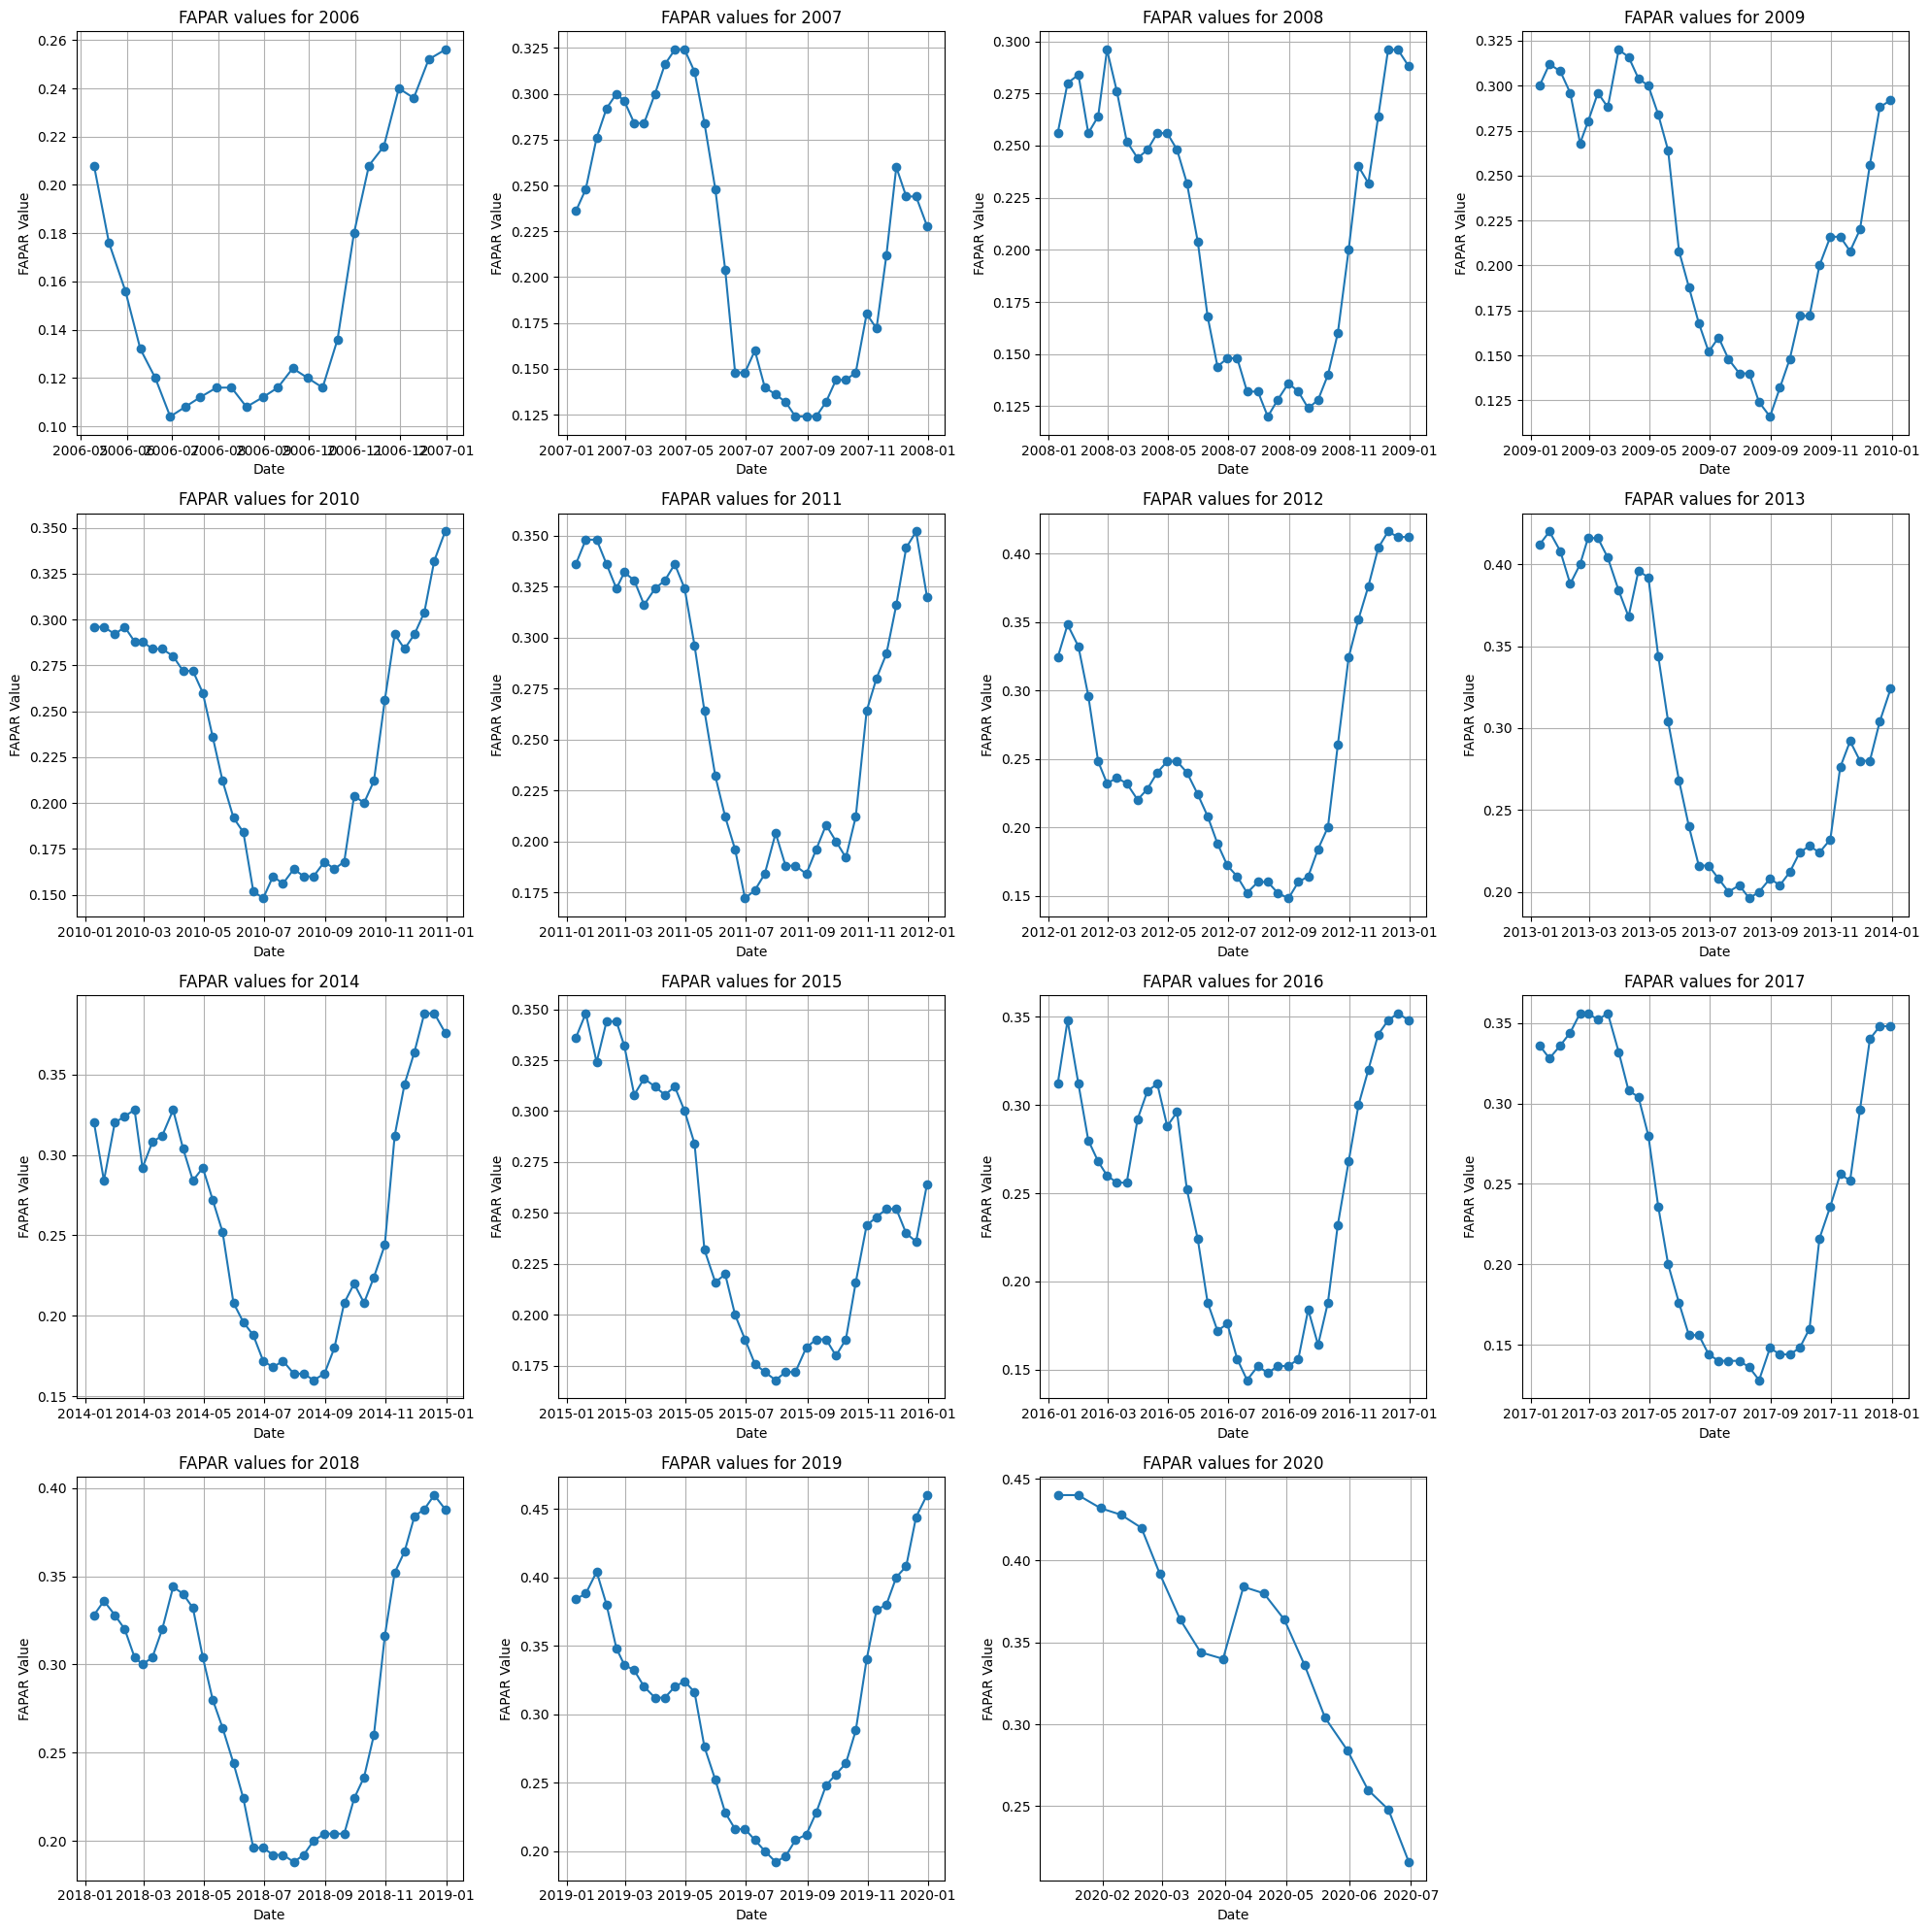

In [40]:
# for year in ds_fapar["date"].dt.year.unique():
#     plt.figure(figsize=(3, 2))
#     plt.plot(ds_fapar[ds_fapar["date"].dt.year == year]["fapar"], marker='o', linestyle='-')
#     plt.title(f"FAPAR values for {year}")
#     plt.xlabel("Date")
#     plt.ylabel("FAPAR Value")
#     plt.grid(True)
#     plt.show()


# Plot for each FAPAR values year

years = ds_fapar["date"].dt.year.unique()

# We'll show 4 year plots per row
num_cols = 4
num_rows = int(np.ceil(len(years) / num_cols))

plt.figure(figsize=(20, num_rows * 5))  # Adjust the figure size as needed

for i, year in enumerate(years):
    plt.subplot(num_rows, num_cols, i + 1)
    yearly_data = ds_fapar[ds_fapar["date"].dt.year == year]
    plt.plot(yearly_data['date'], yearly_data['fapar'], marker='o', linestyle='-')
    plt.title(f"FAPAR values for {year}")
    plt.xlabel("Date")
    plt.ylabel("FAPAR Value")
    plt.grid(True)

plt.tight_layout()
plt.show()

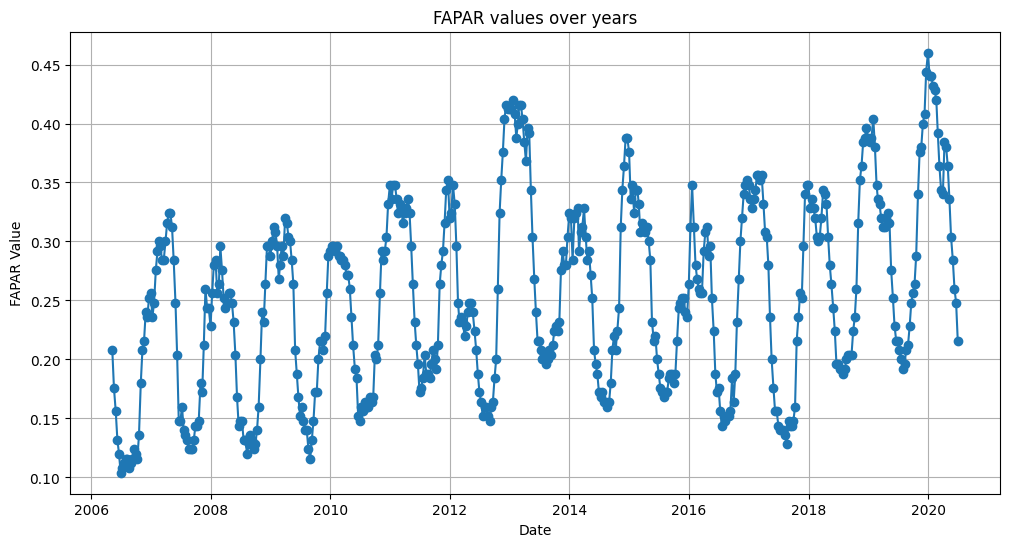

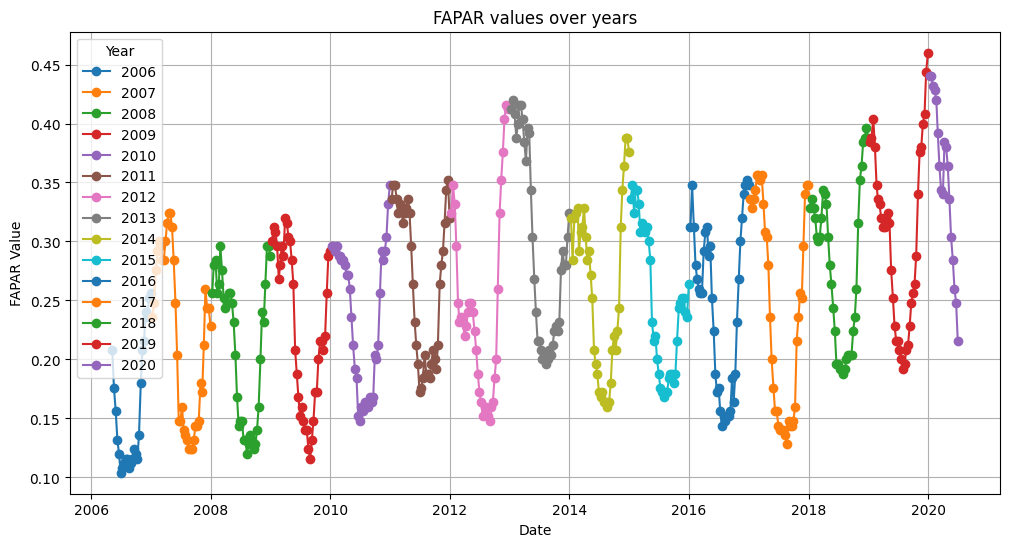

In [41]:
# FAPAR values over the years with and without year division

# Without year division
plt.figure(figsize=(12, 6))
plt.plot(ds_fapar['date'], ds_fapar['fapar'], marker='o', linestyle='-')
plt.title("FAPAR values over years")
plt.xlabel("Date")
plt.ylabel("FAPAR Value")
plt.grid(True)
plt.show()


# With year division
plt.figure(figsize=(12, 6))

for year in ds_fapar["date"].dt.year.unique().tolist():
    # Filter the data for each year and plot it on the same figure
    yearly_data = ds_fapar[ds_fapar["date"].dt.year == year]
    plt.plot(yearly_data['date'], yearly_data['fapar'], marker='o', linestyle='-', label=str(year))

plt.title("FAPAR values over years")
plt.xlabel("Date")
plt.ylabel("FAPAR Value")
plt.legend(title='Year')  # Without this, it's not possible to know which line corresponds to which year
plt.grid(True)
plt.show()


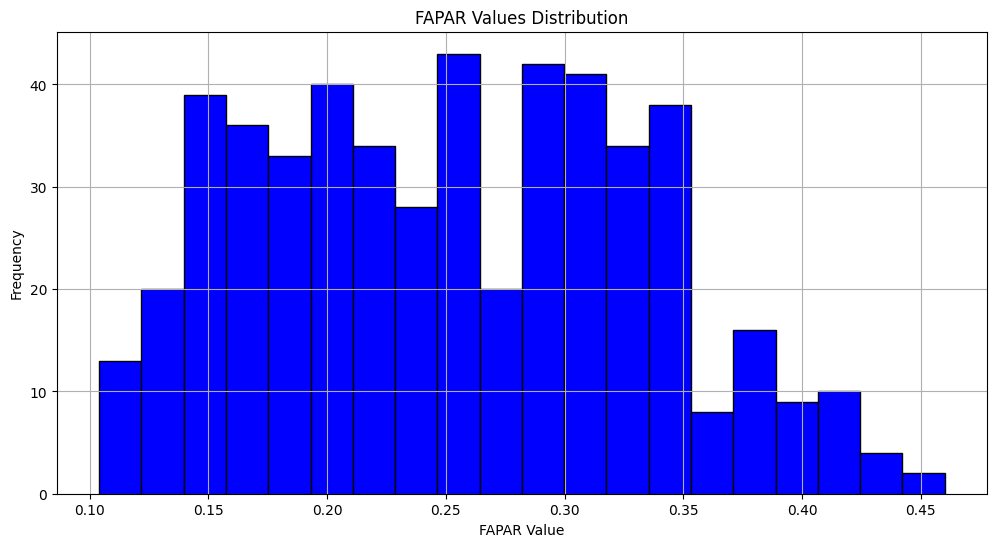

In [42]:
# Histogram of distribution
plt.figure(figsize=(12, 6))
plt.hist(ds_fapar['fapar'], bins=20, color='blue', edgecolor='black')
plt.title('FAPAR Values Distribution')
plt.xlabel('FAPAR Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

NVDI

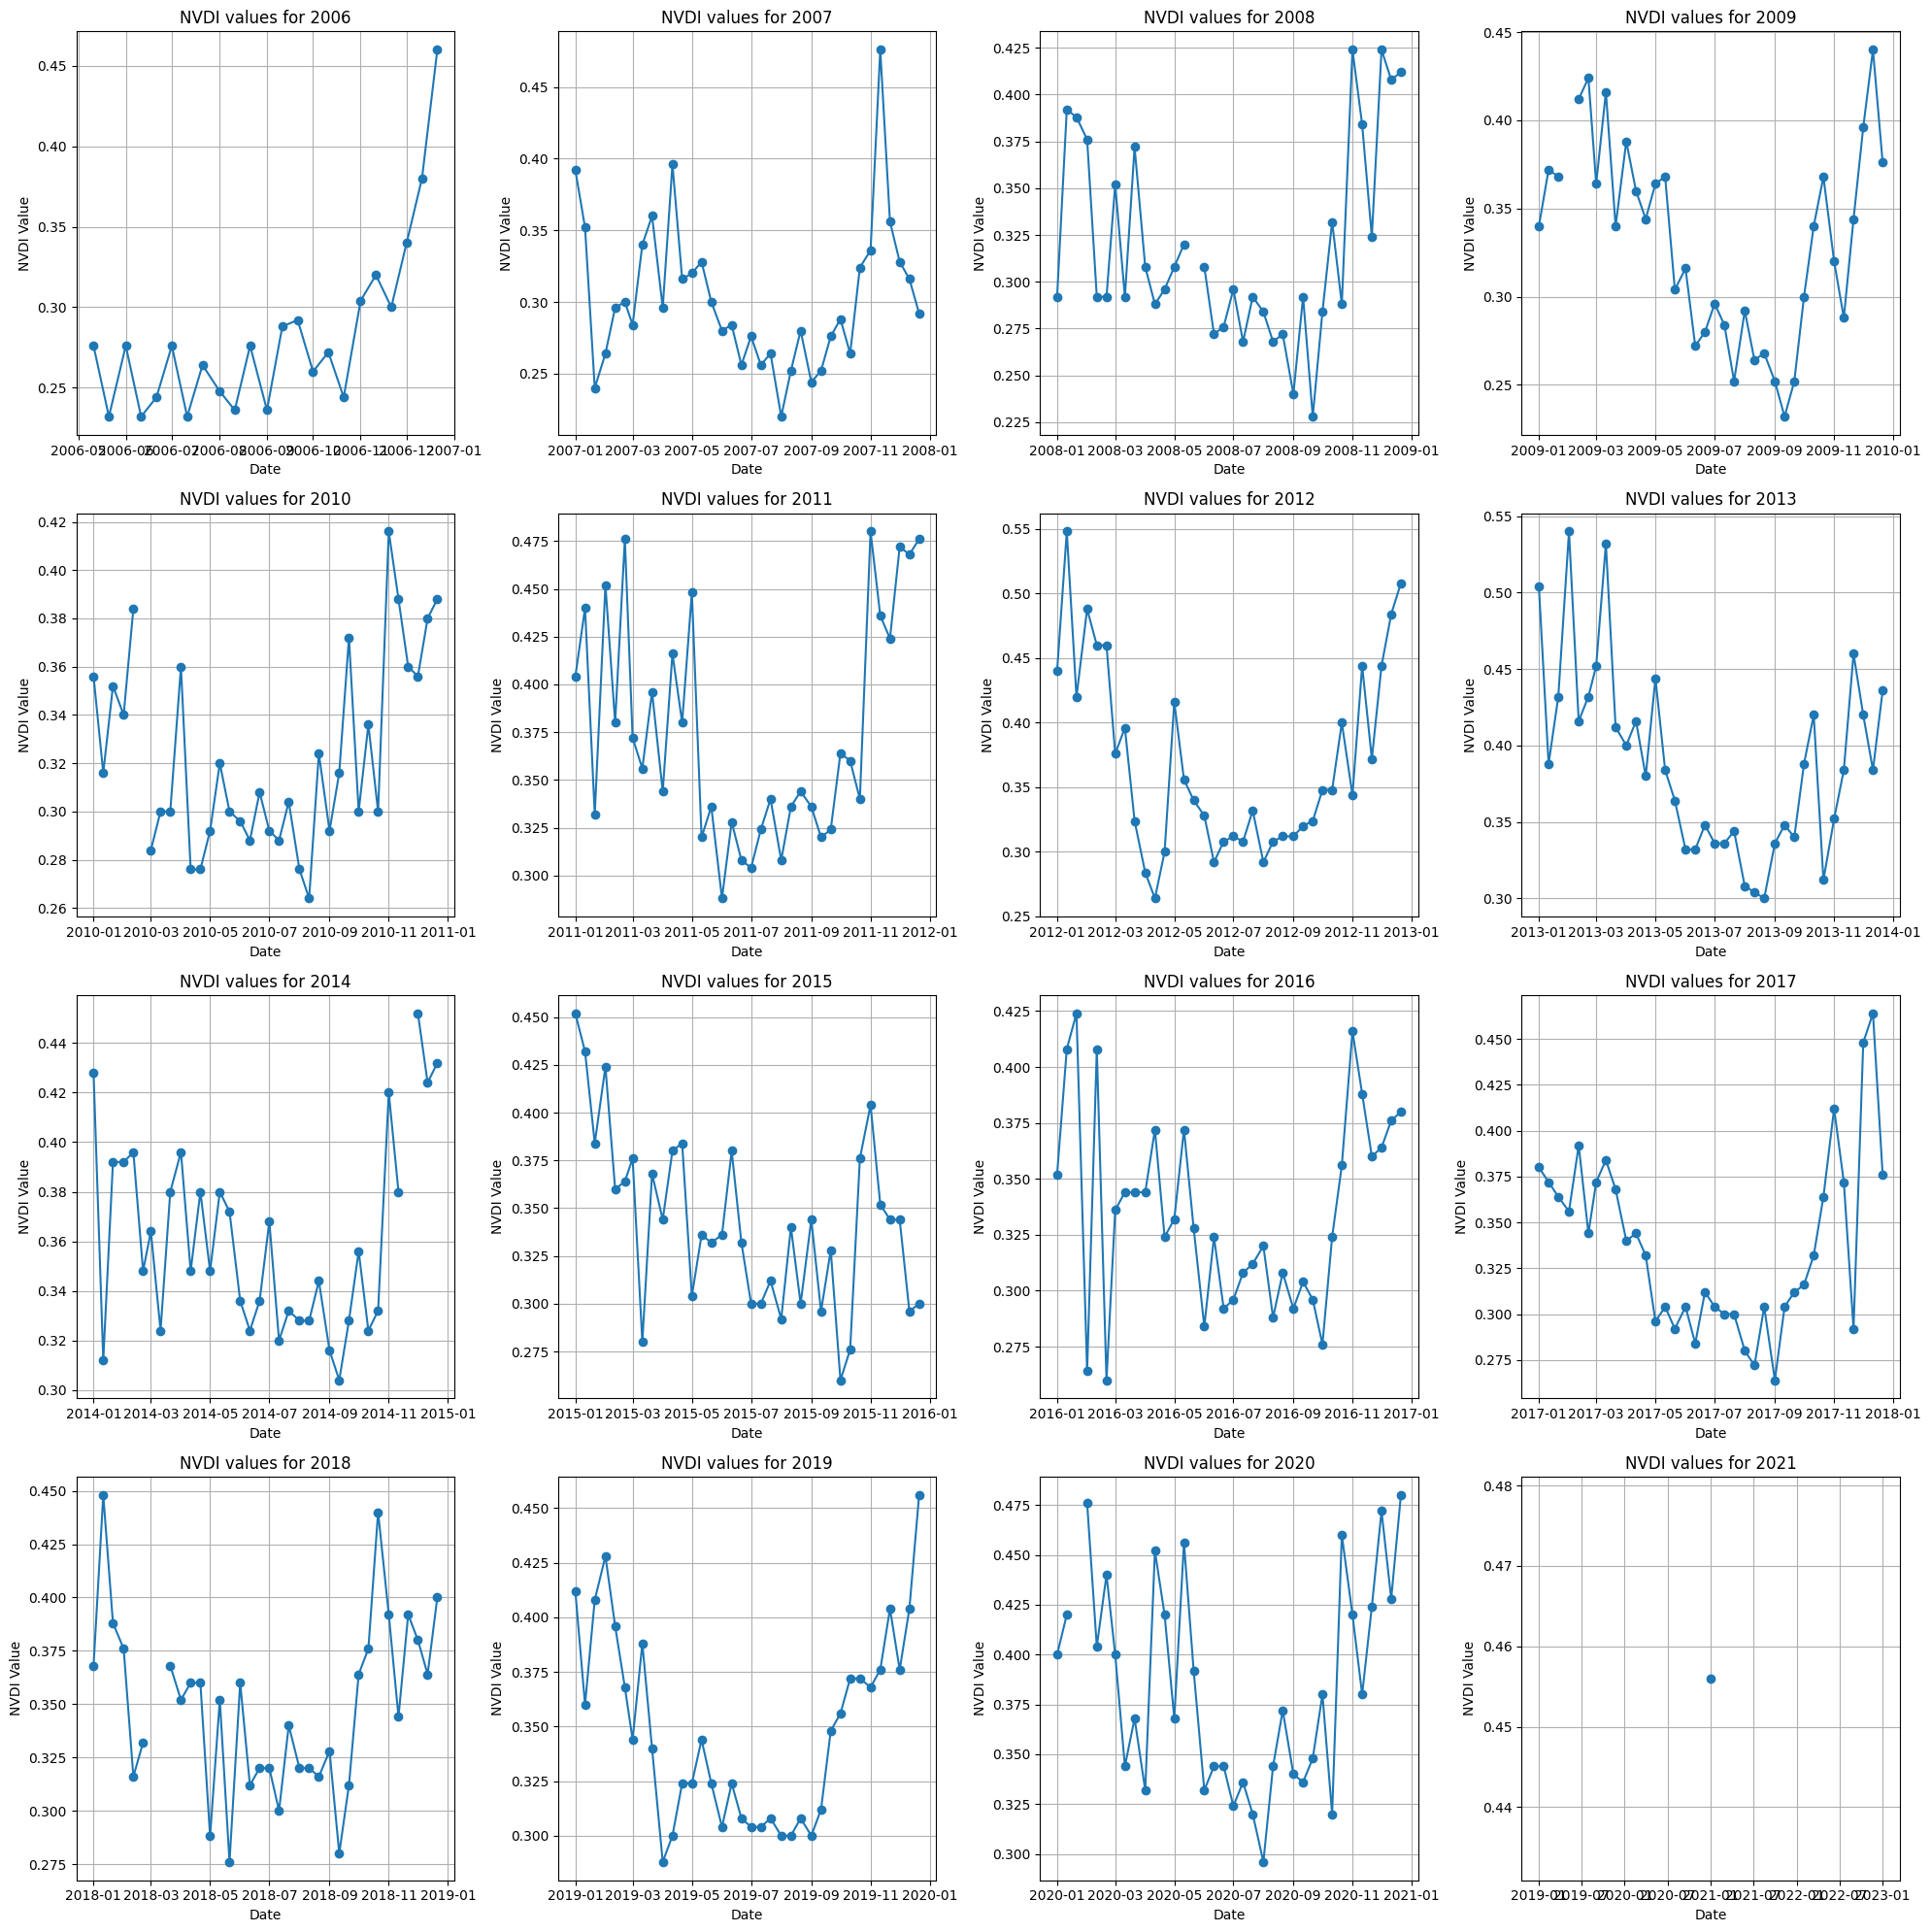

In [43]:
years = ds_nvdi["date"].dt.year.unique()
num_cols = 4
num_rows = int(np.ceil(len(years) / num_cols))

plt.figure(figsize=(20, num_rows * 5))  # Adjust the figure size as needed

for i, year in enumerate(years):
    plt.subplot(num_rows, num_cols, i + 1)
    yearly_data = ds_nvdi[ds_nvdi["date"].dt.year == year]
    plt.plot(yearly_data['date'], yearly_data['nvdi'], marker='o', linestyle='-')
    plt.title(f"NVDI values for {year}")
    plt.xlabel("Date")
    plt.ylabel("NVDI Value")
    plt.grid(True)

plt.tight_layout()
plt.show()

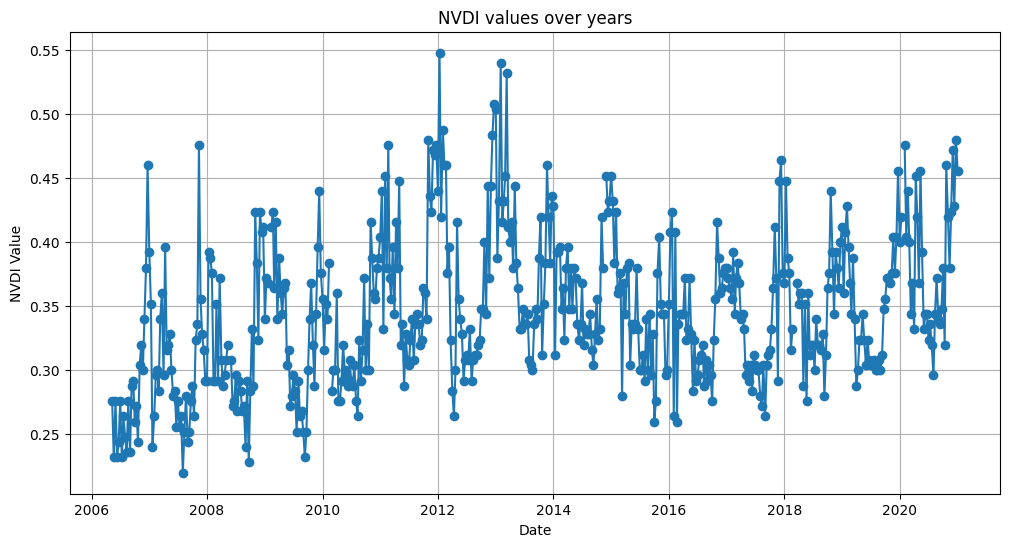

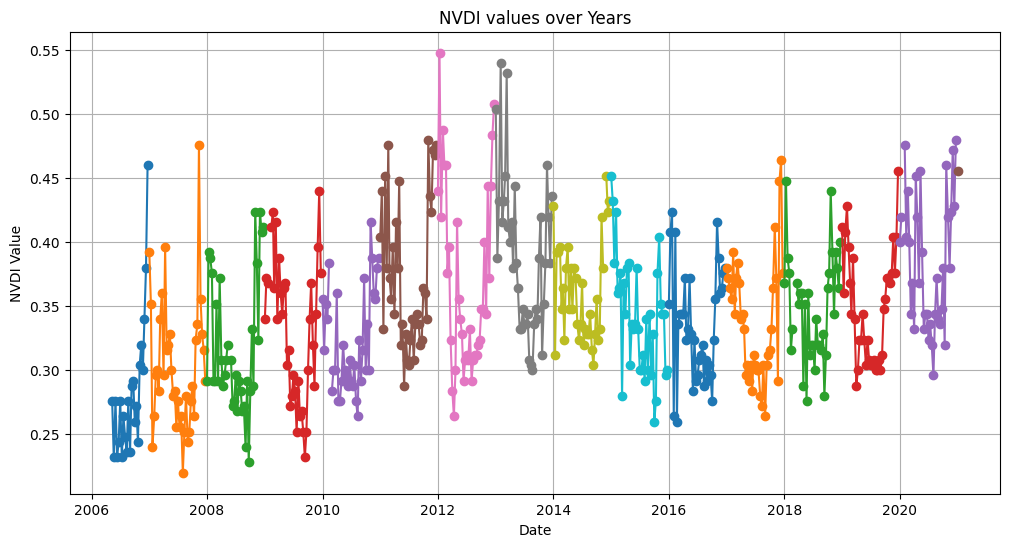

In [44]:
# NVDI values over the years with and without year division

# Without year division
plt.figure(figsize=(12, 6))
plt.plot(ds_nvdi['date'], ds_nvdi['nvdi'], marker='o', linestyle='-')
plt.title("NVDI values over years")
plt.xlabel("Date")
plt.ylabel("NVDI Value")
plt.grid(True)
plt.show()


# With year division
plt.figure(figsize=(12, 6))

for year in ds_nvdi["date"].dt.year.unique().tolist():
    # Filter the data for each year and plot it on the same figure
    yearly_data = ds_nvdi[ds_nvdi["date"].dt.year == year]
    plt.plot(yearly_data['date'], yearly_data['nvdi'], marker='o', linestyle='-', label=str(year))

plt.title("NVDI values over Years")
plt.xlabel("Date")
plt.ylabel("NVDI Value")
plt.grid(True)
plt.show()

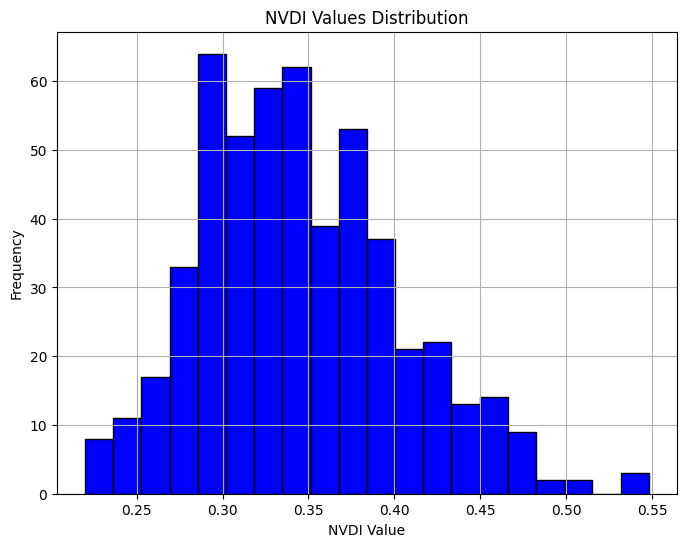

In [45]:
# Histogram of distribution
plt.figure(figsize=(8, 6))
plt.hist(ds_nvdi['nvdi'], bins=20, color='blue', edgecolor='black')
plt.title('NVDI Values Distribution')
plt.xlabel('NVDI Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Outliers in 0.55?

NaNs??
In this case, the time between each value is 10 days apart, doing a mean or LCF wouldn't be a good solution
The best solution is probably to drop them

Other

In [3]:
pd.read_parquet("../data/raw/subset_muestreos_parcelas.parquet")

,generated_muestreos,codparcela,provincia,municipio,fecha,campaña,poligono,parcela,recinto,subrecinto,...,108_u_h_c_a_la_que_pertenece,316_fecha_de_plantación_variedad_secundaria,315_patrón_variedad_secundaria,317_%_superficie_ocupada_variedad_secundaria,306_altura_de_copa_(m),310_patrón_variedad_principal,411_representa_a_la_u_h_c_(si/no),109_sistema_para_el_cumplimiento_gestión_integrada,lat,lon
0,2020-04-23 14:30:39,023-00109-00-00,almeria,abla,2006-04-16,2006,23,109,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.146121,-2.769372
1,2020-04-23 14:30:39,023-00109-00-00,almeria,abla,2006-04-27,2006,23,109,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.146121,-2.769372
2,2020-04-23 14:30:39,023-00109-00-00,almeria,abla,2006-05-04,2006,23,109,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.146121,-2.769372
3,2020-04-23 14:30:39,023-00109-00-00,almeria,abla,2006-05-11,2006,23,109,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.146121,-2.769372
4,2020-04-23 14:30:39,023-00109-00-00,almeria,abla,2006-05-17,2006,23,109,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.146121,-2.769372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581788,2021-04-05 17:26:06,008-00013-01-2,sevilla,villanueva de san juan,2021-03-02,2021,8,13,1,2,...,LAS ATALAYAS,NaN,NaN,NaN,NaN,NaN,SI,Producción Integrada (PI),37.064336,-5.215356
581789,2021-04-05 17:26:06,008-00013-01-2,sevilla,villanueva de san juan,2021-03-09,2021,8,13,1,2,...,LAS ATALAYAS,NaN,NaN,NaN,NaN,NaN,SI,Producción Integrada (PI),37.064336,-5.215356
581790,2021-04-05 17:26:06,008-00013-01-2,sevilla,villanueva de san juan,2021-03-16,2021,8,13,1,2,...,LAS ATALAYAS,NaN,NaN,NaN,NaN,NaN,SI,Producción Integrada (PI),37.064336,-5.215356
581791,2021-04-05 17:26:06,008-00013-01-2,sevilla,villanueva de san juan,2021-03-23,2021,8,13,1,2,...,LAS ATALAYAS,NaN,NaN,NaN,NaN,NaN,SI,Producción Integrada (PI),37.064336,-5.215356


# Conclusions

FAPAR seems to have a parabolic tendency for each year, making a sin function altogether. However, 2020 due to the lack of data, is only half complete. Over the years, we can clearly see the values growing considerably, something to take into account.

NVDI, on the other hand, appears to be much more irregular than FAPAR, it's still possible to see that on the mid months of the year, the values seem to be lower than the beggining / end parts. However, there is still a lot of noise, which, bearing in mind how NVDI is calculated, it could be due to the change of colours of the leafs or the nature in the spring / fall seasons maybe...?